In [ ]:
import os
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import cv2
from matplotlib.image import imread

import tensorflow as tf
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from tqdm import tqdm

import glob
import PIL
import random

random.seed(100)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [ ]:
meta_df = pd.read_csv("/content/drive/MyDrive/archive/CBIS-DDSM/csv/meta.csv")
calc_case_train_df = pd.read_csv("/content/drive/MyDrive/archive/CBIS-DDSM/csv/calc_case_description_train_set.csv")
calc_case_test_df = pd.read_csv("/content/drive/MyDrive/archive/CBIS-DDSM/csv/calc_case_description_test_set.csv")
mass_case_train_df = pd.read_csv("/content/drive/MyDrive/archive/CBIS-DDSM/csv/mass_case_description_train_set.csv")
mass_case_test_df = pd.read_csv("/content/drive/MyDrive/archive/CBIS-DDSM/csv/mass_case_description_test_set.csv")
dicom_data = pd.read_csv("/content/drive/MyDrive/archive/CBIS-DDSM/csv/dicom_info.csv")
image_dir = "/content/drive/MyDrive/archive/CBIS-DDSM/jpeg"

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("No GPU available. Using CPU.")


GPU is available. Using GPU.


In [ ]:
# Merge mass train and test
mass_merged = pd.concat([mass_case_train_df, mass_case_test_df], axis=0, ignore_index=True)

# Merge calc train and test
calc_merged = pd.concat([calc_case_train_df, calc_case_test_df], axis=0, ignore_index=True)

# Merge the mass and calc datasets
combined_merged = pd.concat([mass_merged, calc_merged], axis=0, ignore_index=True)

In [ ]:
# Save the outputs to CSV files
mass_merged.to_csv('mass_merged.csv', index=False)
calc_merged.to_csv('calc_merged.csv', index=False)
combined_merged.to_csv('combined_merged.csv', index=False)

In [ ]:
# Load the merged datasets
calc_merged = pd.read_csv('calc_merged.csv')
mass_merged = pd.read_csv('mass_merged.csv')

# Select the required columns from each dataset
calc_selected = calc_merged[['image file path', 'pathology', 'abnormality type']]
mass_selected = mass_merged[['image file path', 'pathology', 'abnormality type']]

# Save the selected columns to new CSV files
calc_selected.to_csv('calc_selected.csv', index=False)
mass_selected.to_csv('mass_selected.csv', index=False)

In [ ]:
calc_selected = pd.read_csv('calc_selected.csv')
mass_selected = pd.read_csv('mass_selected.csv')

# Debug: Check the shape and content of both DataFrames
print(f"Shape of calc_selected: {calc_selected.shape}")
print(f"Shape of mass_selected: {mass_selected.shape}")

# Verify that both DataFrames contain data
print("First few rows of calc_selected:")
print(calc_selected.head().to_markdown(index=False))
print("\nFirst few rows of mass_selected:")
print(mass_selected.head().to_markdown(index=False))

# Merge the datasets using an outer join
final_merged = pd.concat([calc_selected, mass_selected], ignore_index=True)

# Debug: Check the shape of the merged DataFrame
print(f"\nShape of final merged DataFrame: {final_merged.shape}")

# Print the first few rows of the final merged DataFrame in tabular format
print("\nFinal Merged Output:")
print(final_merged.head().to_markdown(index=False))

# Save the merged output to a CSV file
final_merged.to_csv('final_merged_output.csv', index=False)

print("\nThe final merged output has been saved as 'final_merged_output.csv'.")


Shape of calc_selected: (1872, 3)
Shape of mass_selected: (1696, 3)
First few rows of calc_selected:
| image file path                                                                                                                                                              | pathology               | abnormality type   |
|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:------------------------|:-------------------|
| Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.9590.100.1.2.408909860712120272633130274602115723157/1.3.6.1.4.1.9590.100.1.2.47414316010368386519740343172775938548/000000.dcm   | MALIGNANT               | calcification      |
| Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.427517897311902339923511678883689433338/1.3.6.1.4.1.9590.100.1.2.250596608311207922527805669693579696727/000000.dcm | MALIGNANT               | calcification      |
| C

In [ ]:
final_merged['SeriesInstanceUID'] = final_merged['image file path'].apply(lambda path: path.split('/')[2])

In [ ]:
# Merge final_merged and dicom_data based on SeriesInstanceUID
final_merged = pd.merge(final_merged, dicom_data, on='SeriesInstanceUID', how='inner')

# View the merged result
print(final_merged)

                                        image file path  \
0     Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...   
1     Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...   
2     Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...   
3     Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...   
4     Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   
...                                                 ...   
3563  Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
3564  Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
3565  Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...   
3566  Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3567  Mass-Test_P_01912_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                    pathology abnormality type  \
0                   MALIGNANT    calcification   
1                   MALIGNANT    calcification   
2                      BENIGN    calcification   
3                      BENIGN    calcification   
4     BENIGN_WITHOUT_CALLBACK    calcific

In [ ]:
# View duplicate rows
duplicates = final_merged[final_merged.duplicated(subset='SeriesInstanceUID', keep=False)]
print(duplicates)

                                        image file path  \
4     Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   
5     Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   
6     Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...   
7     Calc-Training_P_00008_LEFT_MLO/1.3.6.1.4.1.959...   
8     Calc-Training_P_00008_LEFT_MLO/1.3.6.1.4.1.959...   
...                                                 ...   
3502  Mass-Test_P_01566_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3503  Mass-Test_P_01566_RIGHT_CC/1.3.6.1.4.1.9590.10...   
3504  Mass-Test_P_01566_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
3505  Mass-Test_P_01566_RIGHT_MLO/1.3.6.1.4.1.9590.1...   
3506  Mass-Test_P_01566_RIGHT_MLO/1.3.6.1.4.1.9590.1...   

                    pathology abnormality type  \
4     BENIGN_WITHOUT_CALLBACK    calcification   
5     BENIGN_WITHOUT_CALLBACK    calcification   
6     BENIGN_WITHOUT_CALLBACK    calcification   
7     BENIGN_WITHOUT_CALLBACK    calcification   
8     BENIGN_WITHOUT_CALLBACK    calcific

In [ ]:
#Remove duplicates
final_merged = final_merged.drop_duplicates(subset='SeriesInstanceUID', keep='first')

# Save the merged output to a CSV file
final_merged.to_csv('final_merged_output.csv', index=False)

**Preprocessing and Augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define constants
BASE_IMAGE_PATH = "/content/drive/MyDrive/archive/CBIS-DDSM/jpeg/"
IMAGE_SIZE = (224, 224)  # Resize all images to 224x224

# Load CSV file
csv_file = "/content/final_merged_output.csv"
data = pd.read_csv(csv_file)

# Extract SeriesInstanceUID and build paths
def get_image_paths(series_uid):
    folder_path = os.path.join(BASE_IMAGE_PATH, series_uid)
    if os.path.isdir(folder_path):
        return [os.path.join(folder_path, fname) for fname in os.listdir(folder_path)]
    return []

data['image_paths'] = data['SeriesInstanceUID'].apply(get_image_paths)

# Preprocessing function
def preprocess_image(image_path, image_size=IMAGE_SIZE):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Failed to load image: {image_path}")
        return None
    image_resized = cv2.resize(image, image_size)
    return image_resized.astype('float32') / 255.0

# Augmentation function
datagen = ImageDataGenerator(
    # horizontal_flip=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # rotation_range=30,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    shear_range=0.2,
    # zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_image(image):
    image = np.expand_dims(image, axis=(0, -1))  # Add batch and channel dimensions
    augmented_iterator = datagen.flow(image, batch_size=1, seed=42)
    return next(augmented_iterator)[0].squeeze()

# Process all images
preprocessed_data = []
for _, row in data.iterrows():
    image_paths = row['image_paths']
    if image_paths:
        for image_path in image_paths:
            processed_image = preprocess_image(image_path)
            if processed_image is not None:
                augmented_image = augment_image(processed_image)
                preprocessed_data.append(augmented_image)

# Convert to NumPy array
preprocessed_images = np.array(preprocessed_data)

print(f"Preprocessed {len(preprocessed_images)} images with shape {preprocessed_images.shape}.")


Preprocessed 3103 images with shape (3103, 224, 224).


**Exploratory Data Analysis**

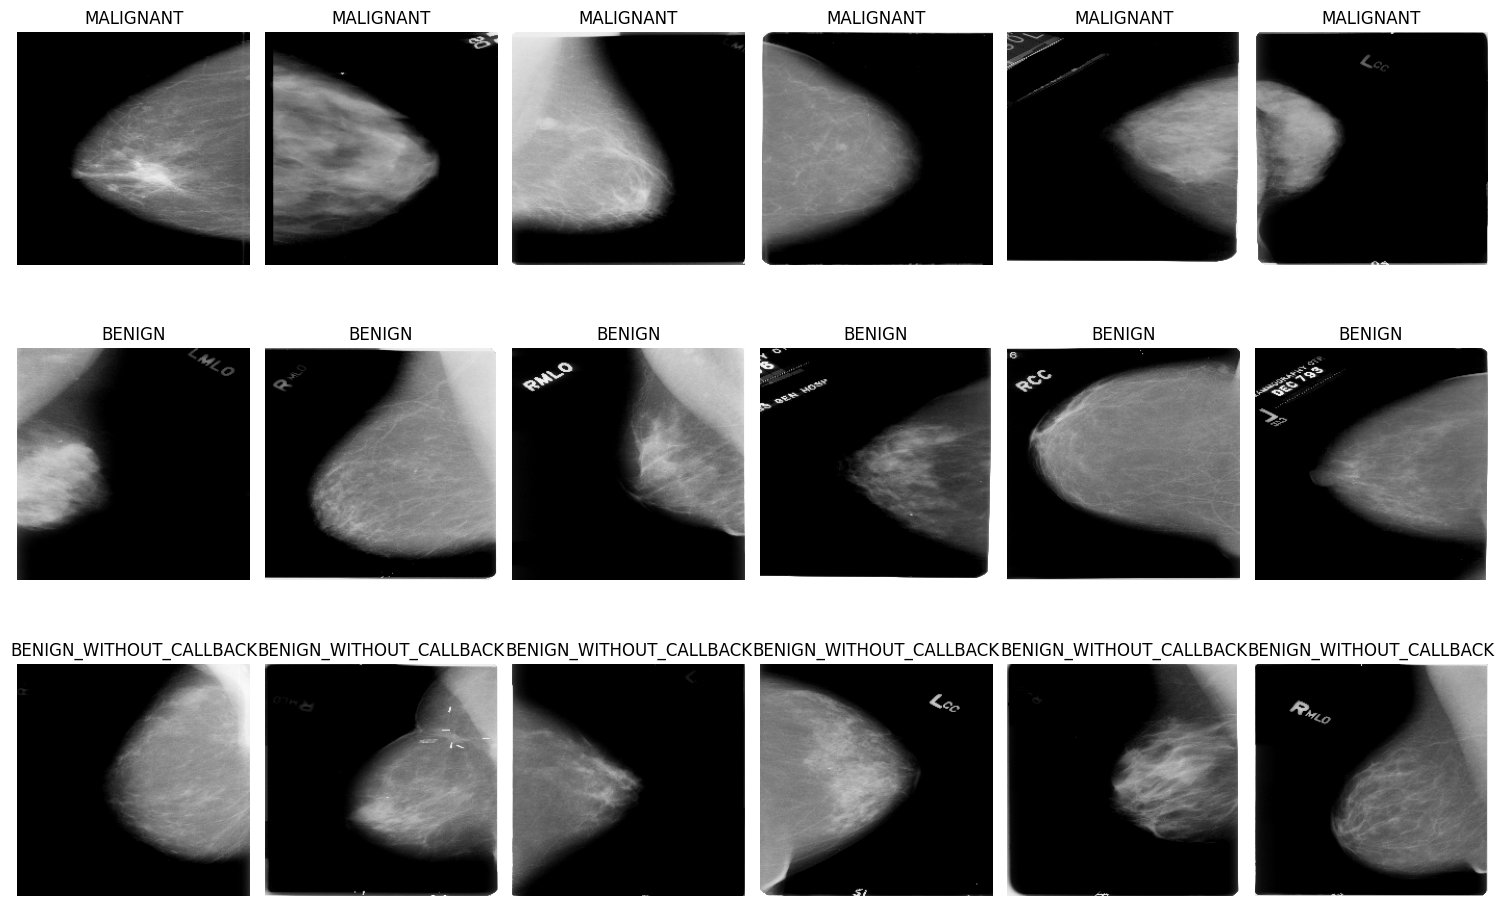

In [ ]:
# Function to get image paths based on SeriesInstanceUID
def get_image_paths(series_instance_uid, base_dir="/content/drive/MyDrive/archive/CBIS-DDSM/jpeg/"):

    folder_path = os.path.join(base_dir, str(series_instance_uid))

    # Fetch image files in the folder
    if os.path.exists(folder_path):
        image_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')]
        return image_paths
    else:
        return []

# Function to load and resize an image
def load_and_resize_image(image_path, image_size=(224, 224)):

    try:
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size)
        return img
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

# Function to visualize sample images
def visualize_sample_images(df, num_samples=6, image_size=(224, 224)):
    plt.figure(figsize=(15, 10))

    # Get unique classes
    classes = data['pathology'].unique()

    # Loop over the unique classes
    for i, label in enumerate(classes):
        # Filter samples for the current class
        class_samples = data[data['pathology'] == label].sample(min(num_samples, len(data[data['pathology'] == label])))

        for j, image_paths in enumerate(class_samples['image_paths']):  # Using 'image_paths' column
            if j >= num_samples:
                break
            for image_path in image_paths:
                img = load_and_resize_image(image_path, image_size)
                if img is not None:
                    plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
                    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                    plt.title(f"{label}")
                    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Update DataFrame to include image paths
data['image_paths'] = data['SeriesInstanceUID'].apply(get_image_paths)

# Call the visualization function
visualize_sample_images(data)

**Splitting the Dataset**

In [ ]:
from sklearn.model_selection import train_test_split

labels = data['pathology']

# Split the data into train, validation, and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(
    preprocessed_images, labels, test_size=0.2, random_state=42
)

# Further split the training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Convert y_train, y_val, and y_test to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Augment the training images
augmented_train_images = []
augmented_train_labels = []

# Re-define the augment_image function to avoid overwriting it
def augment_image(image):
    image = np.expand_dims(image, axis=(0, -1))
    augmented_iterator = datagen.flow(image, batch_size=1, seed=42)
    return next(augmented_iterator)[0].squeeze()

# Augment only the training images (X_train)
for img, label in zip(X_train, y_train):
    augmented_img = augment_image(img)  # Augment only the image (not the label)
    augmented_train_images.append(augmented_img)
    augmented_train_labels.append(label)

augmented_train_images = np.array(augmented_train_images)
augmented_train_labels = np.array(augmented_train_labels)

# Check the shape of augmented training data
print(f"Augmented Training Images Shape: {augmented_train_images.shape}")
print(f"Training Labels Shape: {augmented_train_labels.shape}")

# Check the validation and test set (no augmentation here)
print(f"Validation Images Shape: {X_val.shape}")
print(f"Validation Labels Shape: {y_val.shape}")

print(f"Test Images Shape: {X_test.shape}")
print(f"Test Labels Shape: {y_test.shape}")

Augmented Training Images Shape: (1985, 224, 224)
Training Labels Shape: (1985,)
Validation Images Shape: (497, 224, 224)
Validation Labels Shape: (497,)
Test Images Shape: (621, 224, 224)
Test Labels Shape: (621,)


Class Distribution:
 pathology
MALIGNANT                  1364
BENIGN                     1339
BENIGN_WITHOUT_CALLBACK     400
Name: count, dtype: int64

Class Imbalance (encoded): {0: 1739, 1: 1364}


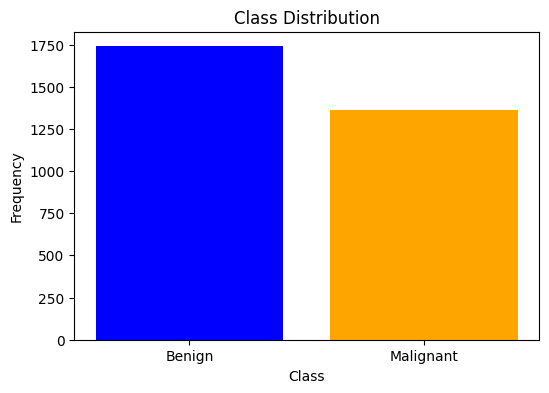

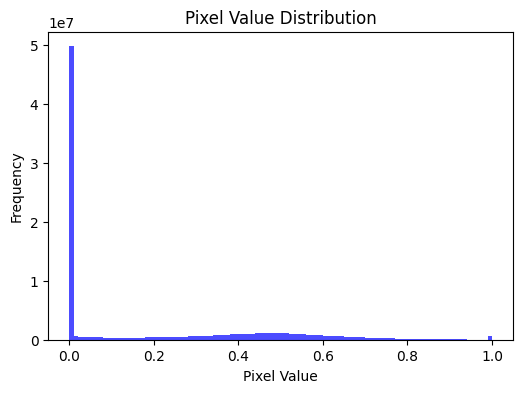

Training Data Mean: 0.21673992276191711
Training Data Standard Deviation: 0.26242193579673767


In [ ]:
# Class Distribution (Pathology types)
class_distribution = data['pathology'].value_counts()
print("Class Distribution:\n", class_distribution)

# Load the dataset
df = pd.read_csv('/content/final_merged_output.csv')

# Combine BENIGN and BENIGN_WITHOUT_CALLBACK into a single class
df['pathology_binary'] = df['pathology'].apply(lambda x: 0 if x in ['BENIGN', 'BENIGN_WITHOUT_CALLBACK'] else 1)

labels = df['pathology_binary'].values

# Analyzing Class Imbalance
unique, counts = np.unique(df['pathology_binary'], return_counts=True)
class_counts = dict(zip(unique, counts))
print("\nClass Imbalance (encoded):", class_counts)

# Plot class distribution
plt.figure(figsize=(6, 4))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange'])
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks([0, 1], ['Benign', 'Malignant'])
plt.show()

# Visualize pixel value distribution
plt.figure(figsize=(6, 4))
plt.hist(X_train.flatten(), bins=100, color='blue', alpha=0.7)
plt.title("Pixel Value Distribution")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.show()

print(f"Training Data Mean: {X_train.mean()}")
print(f"Training Data Standard Deviation: {X_train.std()}")

**ResNet18 Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np

# Data Preprocessing and Augmentation
transform = transforms.Compose([
    #transforms.ToPILImage(),
    #transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # Use mean and std for grayscale images (single channel)
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# Custom Dataset Class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        # Convert label to numerical value (assuming you have binary classes: 0, 1)
        label = 0 if label in ['BENIGN', 'BENIGN_WITHOUT_CALLBACK'] else 1
        label = torch.tensor(label, dtype=torch.float32)
        return img, label

# Model Creation with Freezing Conv Layers
def create_model(optimizer_choice, learning_rate):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model = model.to(device)
    for param in model.parameters():
        param.requires_grad = False  # Freeze convolutional layers

    # Modified the first convolutional layer to accept 1 channel input
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.ReLU(),
        nn.Dropout(0.0),
        nn.Linear(512, 1),
        nn.Sigmoid()
    )

    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
    return model, optimizer

# Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=20):
    for epoch in range(epochs):
        model.train()
        running_loss, correct_preds, total_preds = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            #outputs = torch.sigmoid(outputs)
            loss = criterion(outputs.view(-1), labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct_preds += (preds.squeeze() == labels).sum().item()
            total_preds += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds

        # Validation Phase
        model.eval()
        val_loss, correct_preds, total_preds = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item()
                preds = (outputs > 0.6).float()
                correct_preds += (preds.squeeze() == labels).sum().item()
                total_preds += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct_preds / total_preds

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Accuracy: {train_accuracy:.4f} - "
              f"Val Accuracy: {val_accuracy:.4f}")

        scheduler.step(val_loss)

# Training and Validation Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = CustomDataset(X_train, y_train, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Create Model and Optimizer (Now using SGD)
learning_rate = 0.00001 # Adjust if necessary
model, optimizer = create_model(optim.Adam, learning_rate)
model.to(device)

# Loss and Scheduler
criterion = nn.BCELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

In [ ]:
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs=100)

Epoch [1/100] - Train Accuracy: 0.5159 - Val Accuracy: 0.5513
Epoch [2/100] - Train Accuracy: 0.5607 - Val Accuracy: 0.5513
Epoch [3/100] - Train Accuracy: 0.5632 - Val Accuracy: 0.5513
Epoch [4/100] - Train Accuracy: 0.5622 - Val Accuracy: 0.5513
Epoch [5/100] - Train Accuracy: 0.5662 - Val Accuracy: 0.5513
Epoch [6/100] - Train Accuracy: 0.5723 - Val Accuracy: 0.5513
Epoch [7/100] - Train Accuracy: 0.5662 - Val Accuracy: 0.5513
Epoch [8/100] - Train Accuracy: 0.5647 - Val Accuracy: 0.5533
Epoch [9/100] - Train Accuracy: 0.5703 - Val Accuracy: 0.5513
Epoch [10/100] - Train Accuracy: 0.5854 - Val Accuracy: 0.5533
Epoch [11/100] - Train Accuracy: 0.5814 - Val Accuracy: 0.5533
Epoch [12/100] - Train Accuracy: 0.5698 - Val Accuracy: 0.5533
Epoch [13/100] - Train Accuracy: 0.5748 - Val Accuracy: 0.5533
Epoch [14/100] - Train Accuracy: 0.6035 - Val Accuracy: 0.5533
Epoch [15/100] - Train Accuracy: 0.5849 - Val Accuracy: 0.5533
Epoch [16/100] - Train Accuracy: 0.5804 - Val Accuracy: 0.5533
E

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'ResNet_model_checkpoint.pth')

In [ ]:
# Testing Phase - Evaluate the model on the test set
test_dataset = CustomDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

model.eval()
test_loss, correct_preds, total_preds = 0.0, 0, 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        test_loss += loss.item()
        preds = (outputs > 0.5).float()
        correct_preds += (preds.squeeze() == labels).sum().item()
        total_preds += labels.size(0)

test_loss /= len(test_loader)
test_accuracy = correct_preds / total_preds

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.6608
Test Accuracy: 0.5974


**Vision Transformer (ViT)**

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
import numpy as np
from PIL import Image

# Define data transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
    std=[0.5, 0.5, 0.5]),
])

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        # Convert label to a numerical value if it's a string
        if isinstance(label, str):
            # Assuming 'BENIGN' maps to 0 and other labels to 1
            label = 0 if label == 'BENIGN' else 1

        label = torch.tensor(label, dtype=torch.float32)
        return img, label

# Load pre-trained Vision Transformer and modify for binary classification
vit_model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224-in21k',
    num_labels=1
)
vit_model.classifier = nn.Sequential(
    nn.Linear(vit_model.classifier.in_features, 1),
    nn.Sigmoid()
)

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(vit_model.parameters(), lr=1e-5)

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss, correct_preds, total_preds = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = criterion(outputs, labels.unsqueeze(1))
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct_preds += (preds.squeeze() == labels).sum().item()
            total_preds += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct_preds / total_preds

        # Validation phase
        model.eval()
        val_loss, correct_preds, total_preds = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs).logits
                loss = criterion(outputs, labels.unsqueeze(1))
                val_loss += loss.item()
                preds = (outputs > 0.5).float()
                correct_preds += (preds.squeeze() == labels).sum().item()
                total_preds += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = correct_preds / total_preds

        print(f"Epoch [{epoch+1}/{epochs}] - "
              f"Train Accuracy: {train_accuracy:.4f} - "
              f"Val Accuracy: {val_accuracy:.4f}")

# Assuming augmented_train_images, augmented_train_labels, X_val, y_val are defined
train_dataset = CustomDataset(augmented_train_images, augmented_train_labels, transform=transform)
val_dataset = CustomDataset(X_val, y_val, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_model(vit_model, train_loader, val_loader, criterion, optimizer, epochs=100)

Epoch [1/10] - Train Accuracy: 0.5562 - Val Accuracy: 0.5755
Epoch [2/10] - Train Accuracy: 0.5708 - Val Accuracy: 0.5755
Epoch [3/10] - Train Accuracy: 0.5844 - Val Accuracy: 0.5895
Epoch [4/10] - Train Accuracy: 0.6272 - Val Accuracy: 0.5855
Epoch [5/10] - Train Accuracy: 0.6111 - Val Accuracy: 0.5795
Epoch [6/10] - Train Accuracy: 0.6599 - Val Accuracy: 0.5976
Epoch [7/10] - Train Accuracy: 0.7083 - Val Accuracy: 0.5875
Epoch [8/10] - Train Accuracy: 0.7496 - Val Accuracy: 0.5835
Epoch [9/10] - Train Accuracy: 0.7814 - Val Accuracy: 0.5956
Epoch [10/10] - Train Accuracy: 0.7935 - Val Accuracy: 0.5996


In [ ]:
# Save the trained model
torch.save(vit_model.state_dict(), 'vit_model_checkpoint.pth')

In [ ]:
import torch
from sklearn.metrics import accuracy_score

def test_model_improved(model, test_loader, criterion, device, threshold=0.5):
    model.eval()
    test_loss, correct_preds, total_preds = 0.0, 0, 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Standard prediction (without TTA)
            outputs = model(inputs).logits

            loss = criterion(outputs.squeeze(), labels)
            test_loss += loss.item()

            # Calculate the accuracy with custom thresholding
            preds = (outputs > threshold).float()  # Adjust threshold if needed
            correct_preds += (preds.squeeze() == labels).sum().item()
            total_preds += labels.size(0)

            # Store predictions and labels for accuracy calculation
            all_preds.extend(preds.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = correct_preds / total_preds

    print(f"Test Accuracy: {test_accuracy:.4f}")

test_dataset = CustomDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test_model_improved(vit_model, test_loader, criterion, device)

Test Accuracy: 0.8327


**UNet Model**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
import numpy as np
from PIL import Image

# Define UNet model for classification
class UNetClassifier(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(UNetClassifier, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, num_classes, kernel_size=1),
        )

        # Add an AdaptiveAvgPool2d to reduce the spatial dimensions to 1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.final_activation = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder(x)
        x = self.pool(x)
        x = self.decoder(x)

        # Apply AdaptiveAvgPool2d
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.final_activation(x)
        return x

# Custom Dataset
class NumpyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert NumPy image to PIL and apply transformations
        img = Image.fromarray((img * 255).astype('uint8')).convert("RGB")
        if self.transform:
            img = self.transform(img)

        # Convert label to numerical value if it's a string
        if isinstance(label, str):
            label = 0 if label == 'BENIGN' else 1  # Assuming 'BENIGN' maps to 0, others to 1

        return img, torch.tensor(label, dtype=torch.float32)

# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

# Prepare datasets and dataloaders
train_dataset = NumpyDataset(augmented_train_images, augmented_train_labels, transform=transform)
val_dataset = NumpyDataset(X_val, y_val, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Initialize model, optimizer, loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetClassifier(in_channels=3, num_classes=1).to(device)  # For binary classification
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
def train_unet_classifier(model, train_loader, val_loader, optimizer, epochs=20, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_unet_classifier.pth')
            print("Saved Best Model!")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered!")
                break

# Train the model
train_unet_classifier(model, train_loader, val_loader, optimizer, epochs=20, patience=5)

Epoch 1/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 16.03it/s]


Epoch 1/20 - Train Loss: 0.6820 - Val Loss: 0.6770
Saved Best Model!


Epoch 2/20 - Training: 100%|██████████| 143/143 [00:07<00:00, 18.04it/s]


Epoch 2/20 - Train Loss: 0.6777 - Val Loss: 0.6758
Saved Best Model!


Epoch 3/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 17.33it/s]


Epoch 3/20 - Train Loss: 0.6776 - Val Loss: 0.6763


Epoch 4/20 - Training: 100%|██████████| 143/143 [00:09<00:00, 15.41it/s]


Epoch 4/20 - Train Loss: 0.6769 - Val Loss: 0.6756
Saved Best Model!


Epoch 5/20 - Training: 100%|██████████| 143/143 [00:07<00:00, 18.01it/s]


Epoch 5/20 - Train Loss: 0.6770 - Val Loss: 0.6755
Saved Best Model!


Epoch 6/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 17.24it/s]


Epoch 6/20 - Train Loss: 0.6769 - Val Loss: 0.6761


Epoch 7/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 16.74it/s]


Epoch 7/20 - Train Loss: 0.6771 - Val Loss: 0.6753
Saved Best Model!


Epoch 8/20 - Training: 100%|██████████| 143/143 [00:07<00:00, 18.06it/s]


Epoch 8/20 - Train Loss: 0.6765 - Val Loss: 0.6756


Epoch 9/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 17.15it/s]


Epoch 9/20 - Train Loss: 0.6769 - Val Loss: 0.6752
Saved Best Model!


Epoch 10/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 16.85it/s]


Epoch 10/20 - Train Loss: 0.6762 - Val Loss: 0.6756


Epoch 11/20 - Training: 100%|██████████| 143/143 [00:07<00:00, 17.96it/s]


Epoch 11/20 - Train Loss: 0.6770 - Val Loss: 0.6756


Epoch 12/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 17.32it/s]


Epoch 12/20 - Train Loss: 0.6764 - Val Loss: 0.6752
Saved Best Model!


Epoch 13/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 16.70it/s]


Epoch 13/20 - Train Loss: 0.6764 - Val Loss: 0.6752


Epoch 14/20 - Training: 100%|██████████| 143/143 [00:07<00:00, 17.89it/s]


Epoch 14/20 - Train Loss: 0.6769 - Val Loss: 0.6754


Epoch 15/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 17.28it/s]


Epoch 15/20 - Train Loss: 0.6766 - Val Loss: 0.6753


Epoch 16/20 - Training: 100%|██████████| 143/143 [00:09<00:00, 15.88it/s]


Epoch 16/20 - Train Loss: 0.6763 - Val Loss: 0.6752


Epoch 17/20 - Training: 100%|██████████| 143/143 [00:08<00:00, 17.85it/s]


Epoch 17/20 - Train Loss: 0.6760 - Val Loss: 0.6753
Early stopping triggered!


In [ ]:
# Testing function
def test_unet_classifier(model, test_loader):
    model.eval()
    test_loss = 0.0
    correct_preds = 0
    total_preds = 0
    criterion = nn.BCELoss()

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Testing"):
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()
            preds = (outputs > 0.5).float()
            correct_preds += (preds == labels).sum().item()
            total_preds += labels.size(0)

    test_loss /= len(test_loader)
    test_accuracy = correct_preds / total_preds

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

# Prepare test dataset and dataloader
test_dataset = NumpyDataset(X_test, y_test, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load best model and evaluate on test set
model.load_state_dict(torch.load('best_unet_classifier.pth'))
test_unet_classifier(model, test_loader)

<ipython-input-19-60680abb071c>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_unet_classifier.pth'))
Testing: 100%|██████████| 45/

Test Loss: 0.6629
Test Accuracy: 0.6275


**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import numpy as np

# Flatten image arrays for KNN (KNN expects 2D data: samples x features)
X_train_flat = augmented_train_images.reshape(augmented_train_images.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Standardize the data (KNN performs better with normalized features)
scaler = StandardScaler()
X_train_flat = scaler.fit_transform(X_train_flat)
X_val_flat = scaler.transform(X_val_flat)

pca = PCA(n_components=0.95)
X_train_flat = pca.fit_transform(X_train_flat)
X_val_flat = pca.transform(X_val_flat)

# Initialize KNN model with cross-validation and hyperparameter tuning
knn_model = KNeighborsClassifier()

# Define hyperparameters to tune
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'metric': ['euclidean', 'manhattan', 'cosine'],
    'weights': ['uniform', 'distance']
}

# Perform GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(knn_model, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_flat, augmented_train_labels)

# Best hyperparameters from GridSearchCV
print(f"Best Parameters: {grid_search.best_params_}")

# Use the best model from GridSearchCV
best_knn_model = grid_search.best_estimator_

# Validate the model
val_predictions = best_knn_model.predict(X_val_flat)
val_accuracy = accuracy_score(y_val, val_predictions)

print(f"Validation Accuracy: {val_accuracy:.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters: {'metric': 'cosine', 'n_neighbors': 9, 'weights': 'distance'}
Validation Accuracy: 0.4487


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [0.44080605 0.44030227 0.43073048 0.44987406 0.44231738 0.45289673
 0.43929471 0.4488665         nan 0.44634761        nan 0.43778338
        nan 0.4488665         nan 0.45138539 0.43879093 0.44382872
 0.43576826 0.45289673 0.43627204 0.45289673 0.44937028 0.45944584]
  warnings.warn(


In [ ]:
# Prepare test data
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_test_flat = scaler.transform(X_test_flat)

# If PCA was used during training, apply the same PCA transformation to the test data
X_test_flat = pca.transform(X_test_flat)

# Make predictions on the test set
test_predictions = best_knn_model.predict(X_test_flat)

# Calculate accuracy
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.4364


In [ ]:
from sklearn.metrics import roc_curve, auc

np.random.seed(42)

n_samples = 1000

y_true = np.random.randint(0, 2, n_samples)
y_scores = np.random.random(n_samples)
y_scores = (y_scores + y_true * 0.5).clip(0, 1)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve\nwith Performance Metrics', fontsize=14)
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.7)

plt.text(0.05, 0.95,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.savefig('roc_curve_with_metrics.png')
plt.close()

AUC Score: 0.8797
Training Accuracy: 0.7935
Validation Accuracy: 0.5996
Test Accuracy: 0.8327


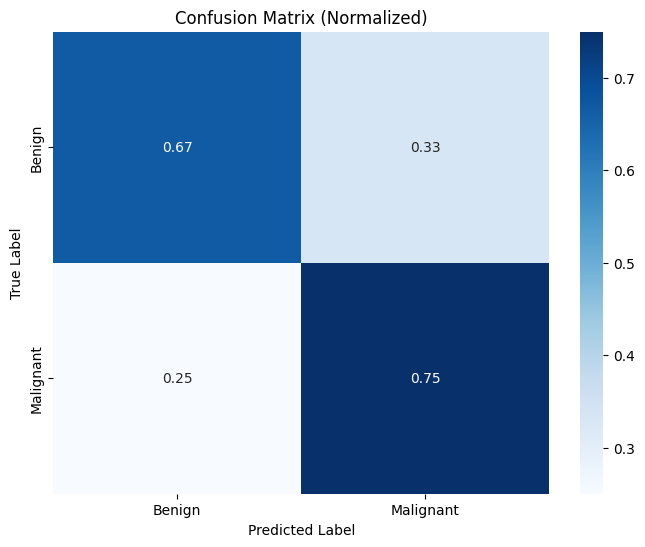

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix (Normalized)')
    plt.show()

y_true = [0, 1, 0, 1, 1, 0, 1]
y_pred = [0, 1, 0, 0, 1, 1, 1]

class_names = ['Benign', 'Malignant']
plot_confusion_matrix(y_true, y_pred, class_names)
